# **Stage 1**
### **Protein and ligand library selection, protein and ligand preparation**

**Choosing the protein**

For this project we have chosen the 5cno protein which can be downloaded at: <br>
https://www.rcsb.org/structure/5CNO <br>
The protein is saved in this repo as 5cno.pdb.
Using PyMOL we have removed solvent, removed organic and added hydrogens. 
The prepared 5cno is saved in this repo as 5cno_prepared.pdb. 

**Choosing the ligand library**

We have chosen the ligand library available for download at: <br>
https://enamine.net/compound-libraries/targeted-libraries/kinase-library <br>
The zipped ligand library is saved in this repo as Enamine_Kinase_Library_plated.zip.
Due to limitations of our personal hardware we have randomly chosen 10k ligands using the sampling.py script
and saved the output as sampled_ligands.sdf. <br>

**Importing necessary libraries**

In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
from rdkit.Chem.rdMolAlign import GetBestRMS
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
import random
import numpy as np
import csv
import json
from openbabel import pybel
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

**Getting the geometric centroid of docking box**

In [4]:
mol = Chem.MolFromPDBFile("5cno.pdb", removeHs=False)
residues = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)

ligand = min(residues, key=lambda x: x.GetNumAtoms())

import numpy as np

def get_centroid(mol):
    """Calculate the geometric center (centroid) of a molecule."""
    conf = mol.GetConformer()
    coords = np.array([conf.GetAtomPosition(i) for i in range(mol.GetNumAtoms())])
    return np.mean(coords, axis=0)

ligand_centroid = get_centroid(ligand)
print(f"Ligand centroid coordinates (x, y, z): {ligand_centroid}")

Ligand centroid coordinates (x, y, z): [-48.405 -37.514  19.017]


**Converting the protein file to .pdbqt for AutoDock Vina compatibility**

In [13]:
subprocess.run(["./convert_to_pdbqt.sh"], check=True)

OSError: [WinError 193] %1 nie jest prawidłową aplikacją systemu Win32

In [5]:
import os
import subprocess
import sys

INPUT_PDB = "5cno_prepared.pdb"
OUTPUT_PDBQT = "5cno_clean.pdbqt"

# Sprawdzenie czy plik wejściowy istnieje
if not os.path.isfile(INPUT_PDB):
    sys.stderr.write(f"❌ Error: Input file {INPUT_PDB} not found!\n")
    sys.exit(1)

# Sprawdzenie czy obabel jest dostępny
if subprocess.call("where obabel", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL) != 0:
    sys.stderr.write("❌ Error: Open Babel (obabel) is not installed!\n")
    sys.stderr.write("Install it with: conda install -c conda-forge openbabel\n")
    sys.exit(1)

# Wykonanie konwersji
print(f"Converting {INPUT_PDB} to {OUTPUT_PDBQT}...")
result = subprocess.run(["obabel", INPUT_PDB, "-O", OUTPUT_PDBQT, "-xr"])

# Sprawdzenie sukcesu
if result.returncode == 0 and os.path.isfile(OUTPUT_PDBQT):
    print(f"✅ Successfully created {OUTPUT_PDBQT}")
    sys.exit(0)
else:
    sys.stderr.write("❌ Error: Conversion failed\n")
    sys.exit(1)


Converting 5cno_prepared.pdb to 5cno_clean.pdbqt...
✅ Successfully created 5cno_clean.pdbqt


SystemExit: 0

c:\Users\micae\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Loading the sampled ligands and clustering them based on their tanimoto similarity. Then adding hydrogens to the sampled ligands. Charges will be added later, due to future format conversions.
We will perform docking on one representative of each cluster, again, due to technical limitations. We will later dock the members of the clusters of top performers.

In [6]:
# loading and embedding ligands from the .sdf file
def load_3d_ligands(sdf_file):
    suppl = Chem.SDMolSupplier(sdf_file, removeHs=False)
    ligands = []
    for mol in suppl:
        if mol is None:
            continue
        mol = Chem.AddHs(mol)
        if AllChem.EmbedMolecule(mol, AllChem.ETKDG()) != 0:
            print("Embedding failed for a molecule, skipping...")
            continue
        AllChem.UFFOptimizeMolecule(mol)
        ligands.append(mol)
    return ligands

# Computing MACCS fingerprints
def get_fingerprints(mols):
    return [rdMolDescriptors.GetMACCSKeysFingerprint(mol) for mol in mols]

# Computing Tanimoto similarity matrix
def tanimoto_similarity(fp_list):
    size = len(fp_list)
    sim_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(i + 1, size):
            sim_matrix[i, j] = DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j])
            sim_matrix[j, i] = sim_matrix[i, j]
    return sim_matrix

# Butina clusterisation
def cluster_ligands(fp_list, cutoff=0.5):
    dists = []
    size = len(fp_list)
    for i in range(1, size):
        for j in range(i):
            dists.append(1 - DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j]))
    clusters = Butina.ClusterData(dists, size, cutoff, isDistData=True)
    return clusters

# Main function
def process_ligands(sdf_file):
    prepared_mols = load_3d_ligands(sdf_file)
    fps = get_fingerprints(prepared_mols)
    clusters = cluster_ligands(fps)
    return clusters, prepared_mols

sdf_file = "sampled_ligands.sdf"
clusters, prepared_ligands = process_ligands(sdf_file)


**Number of clusters:**

In [7]:
len(clusters)

22

**Saving the clusters as clusters.json**

In [8]:
def save_clusters_to_json(clusters, filename):
    # Convert tuple of tuples to list of lists for JSON serialization
    clusters_list = [list(cluster) for cluster in clusters]
    with open(filename, "w") as f:
        json.dump(clusters_list, f, indent=4)

save_clusters_to_json(clusters, "clusters.json")

# To load run:
# def load_clusters_from_json(filename):
#     with open(filename, "r") as f:
#         clusters_list = json.load(f)
#     # Convert each inner list back to a tuple (optional)a
#     clusters = tuple(tuple(cluster) for cluster in clusters_list)
#     return clusters

**Choosing a random ligand from each cluster**

In [18]:
def get_random_ligands_from_clusters(clusters, all_ligands):
    random_ligands = []
    for cluster in clusters:
        # Select a random index from this cluster
        random_idx = random.choice(cluster)
        # Get the corresponding ligand
        random_ligands.append(all_ligands[random_idx])
    return random_ligands

random_ligands = get_random_ligands_from_clusters(clusters, prepared_ligands)

In [19]:
weird = random_ligands[13]

def mol_to_mol(mol):
    mol_block = Chem.MolToV3KMolBlock(mol)
    obmol = pybel.readstring("mol", mol_block)
    charge_model = pybel.ob.OBChargeModel.FindType("gasteiger")
    charge_model.ComputeCharges(obmol.OBMol)
    return obmol

wierd_2 = mol_to_mol(weird)
block_w_2=wierd_2.write('pdbqt')
w_3 = pybel.readstring("pdbqt",block_w_2)

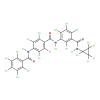

In [20]:
wierd_2

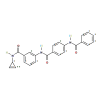

In [21]:
w_3

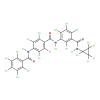

In [22]:
wierd_2

**Saving the drawn ligands into .pdbqt files for AutoDock Vina**

In [25]:
def mol_to_pdbqt(mol, filename):
    if mol.GetNumConformers() == 0:
        raise ValueError(f"Molecule has no conformers: {filename}")
    
    # Convert RDKit Mol to MOL block
    mol_block = Chem.MolToMolBlock(mol)
    
    # Load the MOL block into Open Babel
    obmol = pybel.readstring("mol", mol_block)
    
    # Calculate Gasteiger charges
    charge_model = pybel.ob.OBChargeModel.FindType("gasteiger")
    charge_model.ComputeCharges(obmol.OBMol)
    
    # Write the molecule to a PDBQT file
    obmol.write("pdbqt", filename, overwrite=True)

# Save all prepared ligands
for i, mol in enumerate(random_ligands):
    fname = f"./preprocessed_ligands/ligand_{i+1}.pdbqt"
    mol_to_pdbqt(mol, fname)

# **Stage 2**
### **Virtual screening with molecular docking**

**Docking**

In [14]:
subprocess.run(["./docking.sh"], check=True)

OSError: [WinError 193] %1 nie jest prawidłową aplikacją systemu Win32

In [29]:
# Konfiguracja
RECEPTOR = "5cno_clean.pdbqt"
PREPROCESSED_DIR = "preprocessed_ligands"
DOCKED_DIR = "docked_ligands"
VINA_EXEC = "vina.exe"  # lub ścieżka do vina, np. "C:/vina/vina.exe"

# Parametry dockowania
CENTER_X = -30
CENTER_Y = -10
CENTER_Z = 17
SIZE_X = 10
SIZE_Y = 10
SIZE_Z = 10
SCORING = "vinardo"
EXHAUSTIVENESS = 24

# Tworzenie folderu wyjściowego
os.makedirs(DOCKED_DIR, exist_ok=True)

# Przetwarzanie ligandów 1–22
for i in range(1, 23):
    ligand = os.path.join(PREPROCESSED_DIR, f"ligand_{i}.pdbqt")
    output = os.path.join(DOCKED_DIR, f"docked_ligand_{i}.pdbqt")

    print(f"Docking ligand {i}...")

    if not os.path.isfile(ligand):
        print(f"⚠️ Warning: {ligand} not found, skipping")
        continue

    result = subprocess.run([
        VINA_EXEC,
        "--receptor", RECEPTOR,
        "--ligand", ligand,
        "--center_x", str(CENTER_X),
        "--center_y", str(CENTER_Y),
        "--center_z", str(CENTER_Z),
        "--size_x", str(SIZE_X),
        "--size_y", str(SIZE_Y),
        "--size_z", str(SIZE_Z),
        "--scoring", SCORING,
        "--exhaustiveness", str(EXHAUSTIVENESS),
        "--out", output
    ])

    if result.returncode == 0:
        print(f" Success: {output}")
    else:
        print(f"Error docking ligand {i}")

print(f"\n🎉 Docking complete! Results saved to '{DOCKED_DIR}/'")


Docking ligand 1...
✅ Success: docked_ligands\docked_ligand_1.pdbqt
Docking ligand 2...
✅ Success: docked_ligands\docked_ligand_2.pdbqt
Docking ligand 3...
✅ Success: docked_ligands\docked_ligand_3.pdbqt
Docking ligand 4...
✅ Success: docked_ligands\docked_ligand_4.pdbqt
Docking ligand 5...
✅ Success: docked_ligands\docked_ligand_5.pdbqt
Docking ligand 6...
✅ Success: docked_ligands\docked_ligand_6.pdbqt
Docking ligand 7...
✅ Success: docked_ligands\docked_ligand_7.pdbqt
Docking ligand 8...
✅ Success: docked_ligands\docked_ligand_8.pdbqt
Docking ligand 9...
✅ Success: docked_ligands\docked_ligand_9.pdbqt
Docking ligand 10...
✅ Success: docked_ligands\docked_ligand_10.pdbqt
Docking ligand 11...
✅ Success: docked_ligands\docked_ligand_11.pdbqt
Docking ligand 12...
✅ Success: docked_ligands\docked_ligand_12.pdbqt
Docking ligand 13...
✅ Success: docked_ligands\docked_ligand_13.pdbqt
Docking ligand 14...
✅ Success: docked_ligands\docked_ligand_14.pdbqt
Docking ligand 15...
✅ Success: docked

**Extracting results**

In [30]:
subprocess.run(["./extract_results.sh"], check=True)

OSError: [WinError 193] %1 nie jest prawidłową aplikacją systemu Win32

In [31]:
import os
import re
import csv

MAX_LIGAND = 22
OUTPUT = "vinardo_scores.csv"

# Write CSV header
with open(OUTPUT, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["ligand_number", "vinardo_score"])

    for i in range(1, MAX_LIGAND + 1):
        file = f"./docked_ligands/docked_ligand_{i}.pdbqt"
        if os.path.isfile(file):
            with open(file, 'r') as pdbqt_file:
                for line in pdbqt_file:
                    if line.startswith("REMARK VINA RESULT"):
                        parts = line.strip().split()
                        if len(parts) >= 4:
                            score = parts[3]
                            writer.writerow([i, score])
                        break
        else:
            print(f"Warning: {file} not found, skipping")

print(f"Results saved to {OUTPUT}")


✅ Results saved to vinardo_scores.csv


**Plotting the results**

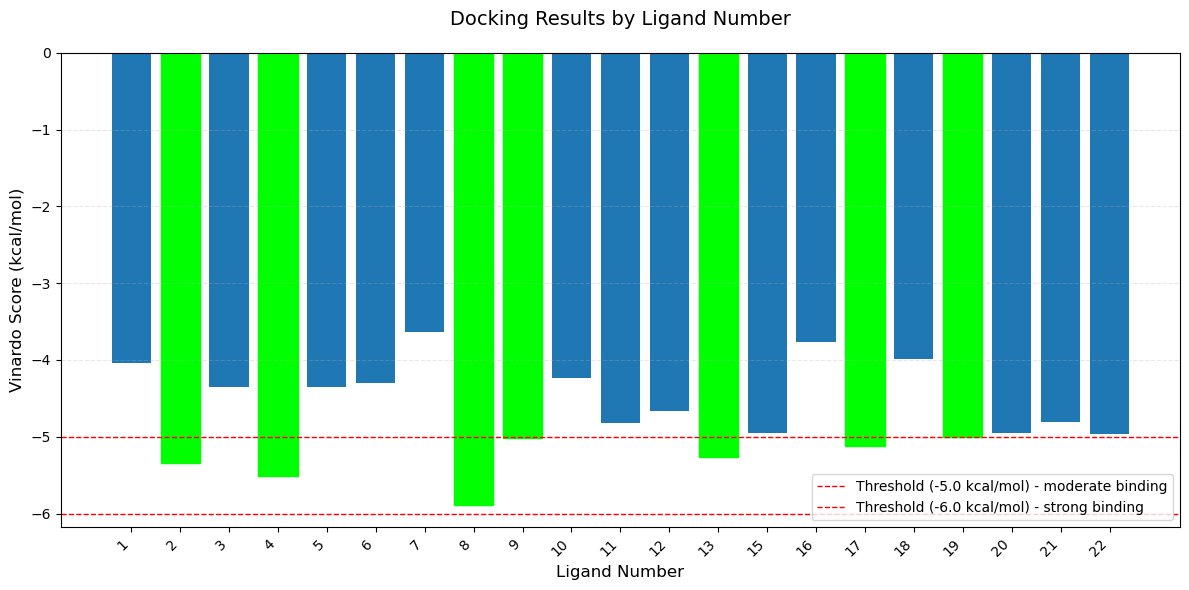

In [17]:
df = pd.read_csv("vinardo_scores.csv")

df = df.sort_values("ligand_number")

plt.figure(figsize=(12, 6))
bars = plt.bar(df["ligand_number"].astype(str), 
               df["vinardo_score"],
               color='#1f77b4')

plt.axhline(y=-5.0, color='red', linestyle='--', linewidth=1, label='Threshold (-5.0 kcal/mol) - moderate binding')
plt.axhline(y=-6.0, color='red', linestyle='--', linewidth=1, label='Threshold (-6.0 kcal/mol) - strong binding')
plt.xlabel("Ligand Number", fontsize=12)
plt.ylabel("Vinardo Score (kcal/mol)", fontsize=12)
plt.title("Docking Results by Ligand Number", fontsize=14, pad=20)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()

# Highlight strong binder
for i, row in df.iterrows():
    if row['vinardo_score'] <= -5.0:
        bars[i].set_color('lime')  # Lime for moderate binders
    if row['vinardo_score'] <= -6.0:
        bars[i].set_color('green')  # Green for strong binders

plt.tight_layout()
plt.show()

**Second phase of looking for best ligands**  
*We are choosing best clusters an choosing more logands from each one in order to find some with binding better than -6.0 kcal/mol*

In [21]:
random.seed(2134)
def get_random_ligands_from_clusters2(clusters, all_ligands):
    random_ligands2 = []
    for cluster_id in {2, 4, 8,20}:
        cluster_indices = clusters[cluster_id]
        for _ in range(10):
            random_idx = random.choice(cluster_indices)
            random_ligands2.append(all_ligands[random_idx])
    return random_ligands2


random_ligands2 = get_random_ligands_from_clusters2(clusters, prepared_ligands)

In [22]:
def mol_to_pdbqt(mol, filename):
    if mol.GetNumConformers() == 0:
        raise ValueError(f"Molecule has no conformers: {filename}")
    
    # Convert RDKit Mol to MOL block
    mol_block = Chem.MolToMolBlock(mol)
    
    # Load the MOL block into Open Babel
    obmol = pybel.readstring("mol", mol_block)
    
    # Calculate Gasteiger charges
    charge_model = pybel.ob.OBChargeModel.FindType("gasteiger")
    charge_model.ComputeCharges(obmol.OBMol)
    
    # Write the molecule to a PDBQT file
    obmol.write("pdbqt", filename, overwrite=True)

# Save all prepared ligands
for i, mol in enumerate(random_ligands2):
    fname = f"./preprocessed_ligands2/ligand_{i+1}.pdbqt"
    mol_to_pdbqt(mol, fname)

In [ ]:
# Konfiguracja
RECEPTOR = "5cno_clean.pdbqt"
PREPROCESSED_DIR = "preprocessed_ligands2"
DOCKED_DIR = "docked_ligands2"
VINA_EXEC = "vina.exe"  # lub ścieżka do vina, np. "C:/vina/vina.exe"

# Parametry dockowania
CENTER_X = -30
CENTER_Y = -10
CENTER_Z = 17
SIZE_X = 10
SIZE_Y = 10
SIZE_Z = 10
SCORING = "vinardo"
EXHAUSTIVENESS = 24

# Tworzenie folderu wyjściowego
os.makedirs(DOCKED_DIR, exist_ok=True)

# Przetwarzanie ligandów 1–22
for i in range(1, 40):
    ligand = os.path.join(PREPROCESSED_DIR, f"ligand_{i}.pdbqt")
    output = os.path.join(DOCKED_DIR, f"docked_ligand_{i}.pdbqt")

    print(f"Docking ligand {i}...")

    if not os.path.isfile(ligand):
        print(f"⚠️ Warning: {ligand} not found, skipping")
        continue

    result = subprocess.run([
        VINA_EXEC,
        "--receptor", RECEPTOR,
        "--ligand", ligand,
        "--center_x", str(CENTER_X),
        "--center_y", str(CENTER_Y),
        "--center_z", str(CENTER_Z),
        "--size_x", str(SIZE_X),
        "--size_y", str(SIZE_Y),
        "--size_z", str(SIZE_Z),
        "--scoring", SCORING,
        "--exhaustiveness", str(EXHAUSTIVENESS),
        "--out", output
    ])

    if result.returncode == 0:
        print(f"✅ Success: {output}")
    else:
        print(f"❌ Error docking ligand {i}")

print(f"\n🎉 Docking complete! Results saved to '{DOCKED_DIR}/'")

Docking ligand 1...
✅ Success: docked_ligands2\docked_ligand_1.pdbqt
Docking ligand 2...
✅ Success: docked_ligands2\docked_ligand_2.pdbqt
Docking ligand 3...
✅ Success: docked_ligands2\docked_ligand_3.pdbqt
Docking ligand 4...
✅ Success: docked_ligands2\docked_ligand_4.pdbqt
Docking ligand 5...
✅ Success: docked_ligands2\docked_ligand_5.pdbqt
Docking ligand 6...
✅ Success: docked_ligands2\docked_ligand_6.pdbqt
Docking ligand 7...
✅ Success: docked_ligands2\docked_ligand_7.pdbqt
Docking ligand 8...
✅ Success: docked_ligands2\docked_ligand_8.pdbqt
Docking ligand 9...
✅ Success: docked_ligands2\docked_ligand_9.pdbqt
Docking ligand 10...
✅ Success: docked_ligands2\docked_ligand_10.pdbqt
Docking ligand 11...
✅ Success: docked_ligands2\docked_ligand_11.pdbqt
Docking ligand 12...
✅ Success: docked_ligands2\docked_ligand_12.pdbqt
Docking ligand 13...
✅ Success: docked_ligands2\docked_ligand_13.pdbqt
Docking ligand 14...
✅ Success: docked_ligands2\docked_ligand_14.pdbqt
Docking ligand 15...
✅ S

In [19]:

MAX_LIGAND = 30
OUTPUT = "vinardo_scores.csv"

# Write CSV header
with open(OUTPUT, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["ligand_number", "vinardo_score"])

    for i in list(range(1, 14)) + list(range(15, 40)):
        file = f"./docked_ligands/docked_ligand_{i}.pdbqt"
        if os.path.isfile(file):
            with open(file, 'r') as pdbqt_file:
                for line in pdbqt_file:
                    if line.startswith("REMARK VINA RESULT"):
                        parts = line.strip().split()
                        if len(parts) >= 4:
                            score = parts[3]
                            writer.writerow([i, score])
                        break
        else:
            print(f"Warning: {file} not found, skipping")

print(f"✅ Results saved to {OUTPUT}")


✅ Results saved to vinardo_scores.csv


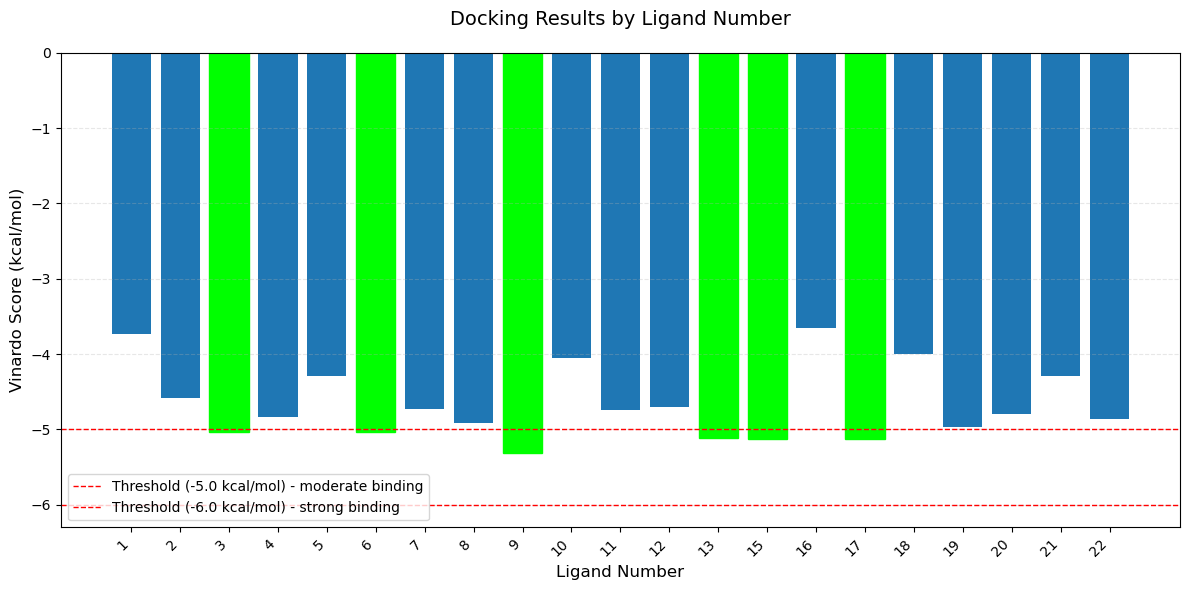

In [ ]:
df = pd.read_csv("vinardo_scores.csv")

df = df.sort_values("ligand_number")

plt.figure(figsize=(12, 6))
bars = plt.bar(df["ligand_number"].astype(str), 
               df["vinardo_score"],
               color='#1f77b4')

plt.axhline(y=-5.0, color='red', linestyle='--', linewidth=1, label='Threshold (-5.0 kcal/mol) - moderate binding')
plt.axhline(y=-6.0, color='red', linestyle='--', linewidth=1, label='Threshold (-6.0 kcal/mol) - strong binding')
plt.xlabel("Ligand Number", fontsize=12)
plt.ylabel("Vinardo Score (kcal/mol)", fontsize=12)
plt.title("Docking Results by Ligand Number", fontsize=14, pad=20)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()

# Highlight strong binder
for i, row in df.iterrows():
    if row['vinardo_score'] <= -5.0:
        bars[i].set_color('lime')  # Lime for moderate binders
    if row['vinardo_score'] <= -6.0:
        bars[i].set_color('green')  # Green for strong binders

plt.tight_layout()
plt.show()